This Projects holds the implementation of a simple neural networks of arbitrary size and backpropagation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def propagate_simple(x, w):
    return np.dot(x,w)

Implementation of one layer

In [12]:
class Perceptrons:
    def __init__(self, n_input, n_output):
        self.w = np.random.rand(n_output,n_input)
        self._activate = lambda x: 1/(1+np.exp(-x))
        self.lr = 0.01
        self._d_activate = lambda x: self._activate(x) * (1 - self._activate(x))
        self.b = np.array(np.random.rand(n_output))

    def propagate(self, x):
        return self._activate(np.dot(self.w, x) + self.b)
    
    def backpropagate(self, x, y):
        delta = np.array(self.propagate(x) - y)
        a_sig = self.propagate(x)
        self.w = np.subtract( self.w, np.dot(np.diag(a_sig), np.dot(delta.reshape(-1,1), x.reshape(1,-1))) * self.lr )
        self.b = np.subtract( self.b, np.dot(np.diag(a_sig),delta))


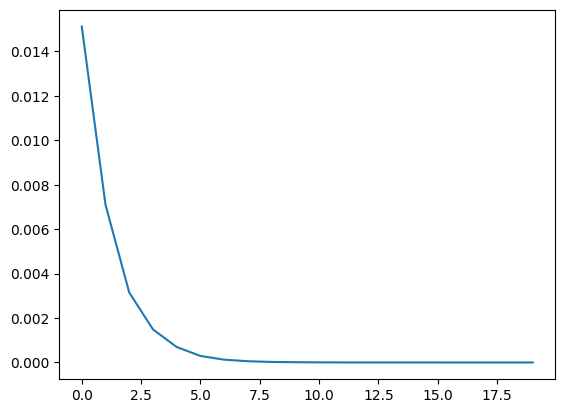

In [13]:
error = []
epoch = 20
iter = 1000
s = Perceptrons(3,2)
test = Perceptrons(3,2)
for i in range(epoch):
    errorSum = 0.0
    for c in range(iter):
        x = np.random.rand(3) * 2 - 1
        errorSum += np.sum(np.square(np.subtract(test.propagate(x), s.propagate(x))))
        s.backpropagate(x, test.propagate(x))
    error.append(errorSum / float(iter))

import matplotlib.pyplot as plt 
plt.plot(error)

Implementation of a Neural Network

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# implement this: https://www.notion.so/Backpropalgo-2083c2ca30a180539ef5e7a3cf1220d8
activationfunctions = {
    "sigmoid": lambda x: 1/(1+np.exp(-x)),
    "relu": lambda x: np.maximum(0, x),
}

d_activationfunctions = {
    "sigmoid": lambda x: activationfunctions["sigmoid"](x) * (1 - activationfunctions["sigmoid"](x)),
    "relu": lambda x: np.where(x > 0, 1, 0),
}

class Layer:
    def __init__(self, n_input, n_output, lr, activation='sigmoid'):
        self.w = np.random.rand(n_output, n_input)
        self._activate = activationfunctions[activation]
        assert activation in activationfunctions, "Activation function not supported"
        self.lr = lr
        self._d_activate = d_activationfunctions[activation]
        assert activation in d_activationfunctions, "Derivative of activation function not supported"
        self.b = np.array(np.random.rand(n_output)).reshape(n_output, 1) # Bias vector reshaped to column vector
        self.x = np.zeros((n_input, 1)) # Input vector
        self.z = np.zeros((n_input, 1)) # Linear combination of inputs and weights
        self.a = np.zeros((n_input, 1)) # Output vector after activation

    def propagate(self, x):
        assert np.shape(x)[0] == self.w.shape[1], "Input shape does not match weight matrix"
        assert np.shape(self.w)[0] == self.b.shape[0], "Weight matrix and bias vector must have the same output dimension"
        
        self.x = x
        self.z = np.dot(self.w, x) + self.b         
        self.a = self._activate(self.z)
        return self.a
    
    def backpropagate(self, delta):
        # dw = delta * da_i/dz_i * dz_i/dw
        # dw b= delta * da_i/dz_i * dz_i/db

        da_dz = self._d_activate(self.z)
        dz_dw = self.x.T
        delta_dz = np.multiply(delta, da_dz)

        dw = np.dot(delta_dz, dz_dw)
        db = delta_dz # * dz_db = 1 
        self.w = np.subtract(self.w, dw * self.lr)
        self.b = np.subtract(self.b, db * self.lr)

    	# delta * da_i/dz_i * dz_i/da_i-1
        # delta * da_i/dz_i = delta_dz
        # dz_i/da_i-1 = self.w.T

        return np.dot(self.w.T, delta_dz)


In [16]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def propagate(self, x):
        for layer in self.layers:
            x = layer.propagate(x)
        return x

    def backpropagate(self, y):
        delta = y
        for layer in reversed(self.layers):
            delta = layer.backpropagate(delta)

In [17]:
class LayerFactory:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.layers = []

    def add_layer(self, n_input, n_output, actiation='sigmoid'):
        layer = Layer(n_input, n_output, self.lr, activation=actiation)
        self.layers.append(layer)
    
    def buildLayers(self):
        layers = self.layers
        self.layers = []
        return layers

In [18]:
def derror(y_true, y_pred):
    return np.subtract(y_pred, y_true) * 2 

def error(y_true, y_pred):
    return np.sum(np.square(derror(y_pred, y_true)))

Testing: neural network "learns" the output of a randomly initialized network 

In [1]:
layerfac = LayerFactory(lr=0.01)
layerfac.add_layer(2, 3, 'sigmoid')
layerfac.add_layer(3, 1, 'sigmoid')
teacher = NeuralNetwork(layerfac.buildLayers())
layerfac.add_layer(2, 3, 'sigmoid')
layerfac.add_layer(3, 1, 'sigmoid')
student = NeuralNetwork(layerfac.buildLayers())

error_record = []

epoch = 20
iter = 1000

for i in range(epoch):
    errorSum = 0.0
    for c in range(iter):
        x = np.random.rand(2).reshape(2, 1) * 2 - 1
        y = teacher.propagate(x)
        errorSum += error(y, student.propagate(x))
        student.backpropagate(derror(y, student.propagate(x)))
    error_record.append(errorSum / float(iter))
    print(f"Epoch {i}, Error: {errorSum / float(iter)}")

"""
for i in range(80000):
    x = np.random.rand(2).reshape(2, 1) * 2 - 1
    y = teacher.propagate(x)
    y_pred = student.propagate(x)
    student.backpropagate(derror(y, y_pred))

    if i % 100 == 0:
        if i % 10000 == 0:
            print(f"teacher output: {y.flatten()}")
            print(f"student output: {y_pred.flatten()}")
            print(f"Epoch {i}, Error: {error(y, y_pred)}")
        error_record.append(error(y, y_pred))"""

plt.plot(error_record)

NameError: name 'LayerFactory' is not defined